In [ ]:
!pip install requirements.txt 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#for pre-processing
from sklearn.model_selection import train_test_split

#for model construction #neural network
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

#for model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  #hide any pandas warnings

import configparser
import mesa
import networkx as nx
import math

In [8]:
config = configparser.ConfigParser()
config.read('config.ini')

population = int(config['DEFAULT']['population'])
avg_node_degree = int(config['DEFAULT']['avg_node_degree'])
initial_outbreak_size = int(config['DEFAULT']['initial_outbreak_size'])
disease_spread_chance = float(config['DEFAULT']['disease_spread_chance'])
disease_check_frequency = float(config['DEFAULT']['disease_check_frequency'])
recovery_chance = float(config['DEFAULT']['recovery_chance'])
curing_days = int(config['DEFAULT']['curing_days'])
testing_days = int(config['DEFAULT']['testing_days'])
time_steps = int(config['DEFAULT']['time_steps'])
wasinfected = config['DEFAULT'].getboolean('wasinfected')
wasresistant = config['DEFAULT'].getboolean('wasresistant')
isolation_factor = float(config['DEFAULT']['isolation_factor'])
resistant_chance_multiplier = float(config['DEFAULT']['resistant_chance_multiplier'])

## DiseaseModel et DiseaseAgent ABM

Définit différents états pour les agents, notamment sensible, infecté, résistant, isolé et mort.

In [9]:
# Define states of agents
class State:
    SUSCEPTIBLE = 0
    INFECTED = 1
    RESISTANT = 2
    ISOLATED = 3
    DEAD = 4

# Function to count agents in a specific state
def number_state(model, state):
    return sum(1 for a in model.grid.get_all_cell_contents() if a.state is state)

# Functions to count specific states of agents
def number_infected(model):
    return number_state(model, State.INFECTED)

def number_susceptible(model):
    return number_state(model, State.SUSCEPTIBLE)

def number_resistant(model):
    return number_state(model, State.RESISTANT)

def number_dead(model):
    return number_state(model, State.DEAD)

def number_isolated(model):
    return number_state(model, State.ISOLATED)

# Class representing the virus spreading model on a network
class DeaseseModel(mesa.Model):
    """
    A virus spreading model on a network.

    Args:
        num_nodes (int): Number of nodes in the network.
        avg_node_degree (int): Average node degree in the network.
        initial_outbreak_size (int): Initial number of infected nodes.
        disease_spread_chance (float): Probability of spreading the virus to neighbors.
        disease_check_frequency (float): Frequency of checking for virus spread.
        recovery_chance (float): Probability of recovering from the infection.
        curing_days (int): Duration for curing the infection.
        testing_days (int): Duration for testing the infection.
        time_steps (int): Current time step.
        wasinfected (bool): Whether the agent was initially infected.
        wasresistant (bool): Whether the agent was initially resistant.
        isolation_factor (float): Factor determining the likelihood of isolation.
        resistant_chance_multiplier (float): Multiplier affecting the resistance chance.
    """

    def __init__(
        self,
        num_nodes=population,
        avg_node_degree=6,
        initial_outbreak_size=2,
        disease_spread_chance=0.1,
        disease_check_frequency=0.2,
        recovery_chance=0.1,
        curing_days=0,
        testing_days=0,
        time_steps=0,
        wasinfected=False,
        wasresistant=False,
        isolation_factor=0.3,
        resistant_chance_multiplier=0.55
    ):
        """
        Initialize the DeaseseModel model.

        Creates a network graph, places agents on the graph, and initializes model parameters.

        Args:
            num_nodes (int): Number of nodes in the network.
            avg_node_degree (int): Average node degree in the network.
            initial_outbreak_size (int): Initial number of infected nodes.
            disease_spread_chance (float): Probability of spreading the virus to neighbors.
            disease_check_frequency (float): Frequency of checking for virus spread.
            recovery_chance (float): Probability of recovering from the infection.
            curing_days (int): Duration for curing the infection.
            testing_days (int): Duration for testing the infection.
            time_steps (int): Current time step.
            wasinfected (bool): Whether the agent was initially infected.
            wasresistant (bool): Whether the agent was initially resistant.
            isolation_factor (float): Factor determining the likelihood of isolation.
            resistant_chance_multiplier (float): Multiplier affecting the resistance chance.
        """
        super().__init__()
        # Initialize network graph
        self.num_nodes = num_nodes
        prob = avg_node_degree / self.num_nodes
        self.G = nx.erdos_renyi_graph(n=self.num_nodes, p=prob)
        self.grid = mesa.space.NetworkGrid(self.G)
        self.schedule = mesa.time.RandomActivation(self)
        self.initial_outbreak_size = initial_outbreak_size 
        self.disease_spread_chance = disease_spread_chance
        self.disease_check_frequency = disease_check_frequency
        self.recovery_chance = recovery_chance
        self.curing_days = curing_days
        self.testing_days = testing_days
        self.time_steps = time_steps
        self.wasinfected = wasinfected
        self.wasresistant = wasresistant 
        self.isolation_factor = isolation_factor
        self.resistant_chance_multiplier = resistant_chance_multiplier

        # Data collector for gathering model statistics
        self.datacollector = mesa.DataCollector(
            {
                "Infected": number_infected,
                "Susceptible": number_susceptible,
                "Resistant": number_resistant,
                "Dead": number_dead,
                "Isolated": number_isolated
            }
        )

        # Create agents and place them on the network
        for i, node in enumerate(self.G.nodes()):
            a = DiseaseAgent(
                i,
                self,
                State.SUSCEPTIBLE,
                self.disease_spread_chance,
                self.disease_check_frequency,
                self.recovery_chance,
                self.curing_days,
                self.testing_days,
                self.time_steps,
                self.wasinfected,
                self.wasresistant
            )
            self.schedule.add(a)
            # Add the agent to the node
            self.grid.place_agent(a, node)

        # Infect some nodes at the start
        infected_nodes = self.random.sample(list(self.G), self.initial_outbreak_size)
        for a in self.grid.get_cell_list_contents(infected_nodes):
            a.state = State.INFECTED
            a.wasinfected = True 

        self.running = True
        self.datacollector.collect(self)

    # Function to calculate the ratio of resistant to susceptible agents
    def resistant_susceptible_ratio(self):
        """
        Calculate the ratio of resistant to susceptible agents.

        Returns:
            float: The ratio of resistant to susceptible agents.
        """
        try:
            return number_state(self, State.RESISTANT) / number_state(
                self, State.SUSCEPTIBLE
            )
        except ZeroDivisionError:
            return math.inf

    # Execute one step of the model
    def step(self):
        """
        Execute one step of the model.

        This involves activating each agent in a random order and updating their states.
        """
        self.schedule.step()
        # Collect data for this step
        self.datacollector.collect(self)

    # Run the model for n steps
    def run_model(self, n):
        """
        Run the model for a specified number of steps.

        Args:
            n (int): Number of steps to run the model for.
        """
        for i in range(n):
            self.step()

In [10]:
class DiseaseAgent(mesa.Agent):
    def __init__(
        self,
        unique_id,
        model,
        initial_state,
        disease_spread_chance,
        disease_check_frequency,
        recovery_chance,
        curing_days,
        testing_days,
        time_steps,
        wasinfected,
        wasresistant
    ):
        """
        Initialize an Agent.
        
        Args:
            unique_id (int): Unique identifier for the agent.
            model (DeseaseModel): Reference to the model.
            initial_state (State): Initial state of the agent.
            disease_spread_chance (float): Probability of spreading the virus to neighbors.
            disease_check_frequency (float): Frequency of checking for virus spread.
            recovery_chance (float): Probability of recovering from the infection.
            curing_days (int): Duration for curing the infection.
            testing_days (int): Duration for testing the infection.
            time_steps (int): Current time step.
            wasinfected (bool): Whether the agent was initially infected.
            wasresistant (bool): Whether the agent was initially resistant.
        """
        super().__init__(unique_id, model)

        self.state = initial_state

        self.disease_spread_chance = disease_spread_chance
        self.disease_check_frequency = disease_check_frequency
        self.recovery_chance = recovery_chance
        self.curing_days = curing_days
        self.testing_days = testing_days
        self.time_steps = time_steps
        self.wasinfected = wasinfected
        self.wasresistant = wasresistant

    def try_to_infect_neighbors(self):
        """
        Attempt to infect neighboring agents based on virus spread chance.
        """
        neighbors_nodes = self.model.grid.get_neighborhood(
            self.pos, include_center=False
        )

        healthy_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state == State.SUSCEPTIBLE or agent.state == State.RESISTANT
        ]

        for a in healthy_neighbors:
            chance = self.decide_disease_spread_chance(a)
            if self.random.random() < chance:
                a.state = State.INFECTED
                a.wasinfected = True 

    def decide_disease_spread_chance(self, neighbor):
        """
        Determine virus spread chance to a neighbor.
        """
        resistant_neighbor = neighbor.wasinfected or neighbor.wasresistant

        if not resistant_neighbor:
            chance = self.disease_spread_chance
        else:
            chance = self.disease_spread_chance * (1 - 0.84)

        if self.state == State.ISOLATED:
            chance *= self.model.isolation_factor

        if self.wasresistant:
            return chance * self.model.resistant_chance_multiplier
        else:
            return chance 

    def step(self):
        """
        Execute one step of agent behavior.
        """
        if self.state is State.INFECTED:
            self.try_to_infect_neighbors()

        if self.state == State.INFECTED:
            if self.testing_days == 7:
                self.state = State.ISOLATED
                self.testing_days = 0
            else:
                self.testing_days += 1

        if self.state == State.ISOLATED:
            if self.curing_days == 30:
                if self.random.random() < self.recovery_chance:
                    self.state = State.SUSCEPTIBLE
                else:
                    self.state = State.DEAD 
                self.curing_days = 0
        else:
            self.curing_days += 1

        if self.state == State.SUSCEPTIBLE:
            vaccination_rate = 0.02 
            if self.random.random() < vaccination_rate:
                self.state = State.RESISTANT
                self.wasresistant = True 

        self.time_steps += 1


## Creation du dataset

In [11]:
number_of_steps = 60

dataset_all = pd.DataFrame()

for iteration in range(100):
    model = DeaseseModel()
    number_agents = np.zeros((3, number_of_steps))

    for i in range(number_of_steps):
        # Store the number of infected
        number_agents[0, i] = number_infected(model)
        number_agents[1, i] = number_resistant(model)
        number_agents[2, i] = number_susceptible(model)
        model.step()

    reshape_data_all = np.reshape(number_agents, (1, 3 * number_of_steps))
    dataset_all = pd.concat([dataset_all, pd.DataFrame(reshape_data_all)])

# Generate column names dynamically
columns_all = [f"{agent}{n}" for agent in ['Infected', 'Resistant', 'Susceptible'] for n in range(number_of_steps)]

# Assign column names to the DataFrame
dataset_all.columns = columns_all

# Calculate daily scores
infected_scores = np.mean(dataset_all.iloc[:, :number_of_steps].values, axis=0)
resistant_scores = np.mean(dataset_all.iloc[:, number_of_steps:2 * number_of_steps].values, axis=0)
susceptible_scores = np.mean(dataset_all.iloc[:, 2 * number_of_steps:].values, axis=0)

dataset_all = pd.DataFrame(dataset_all)
# Create a new DataFrame for daily scores
daily_scores = pd.DataFrame({'Infected': infected_scores, 'Resistant': resistant_scores, 'Susceptible': susceptible_scores})

print(daily_scores)

    Infected  Resistant  Susceptible
0       2.00       0.00      1998.00
1       3.11      40.74      1956.15
2       5.43      80.72      1913.85
3       9.11     118.33      1872.56
4      15.24     155.51      1829.25
5      24.21     191.97      1783.82
6      38.56     227.48      1733.96
7      60.69     261.61      1677.70
8      89.52     292.71      1615.31
9     132.09     322.86      1540.93
10    188.72     350.11      1454.18
11    262.39     374.87      1350.86
12    350.44     396.36      1233.65
13    450.94     412.09      1106.11
14    552.93     424.65       973.12
15    655.40     432.29       837.39
16    746.35     435.06       706.54
17    814.51     433.25       587.96
18    852.96     428.39       484.88
19    862.60     420.66       396.71
20    840.36     412.15       324.16
21    790.89     403.07       265.62
22    718.27     394.47       221.58
23    632.28     386.90       186.38
24    542.22     380.13       159.93
25    451.68     374.30       141.14
2

In [12]:
dataset_all.head(5)

,Infected0,Infected1,Infected2,Infected3,Infected4,Infected5,Infected6,Infected7,Infected8,Infected9,...,Susceptible50,Susceptible51,Susceptible52,Susceptible53,Susceptible54,Susceptible55,Susceptible56,Susceptible57,Susceptible58,Susceptible59
0,2.0,3.0,3.0,4.0,6.0,7.0,8.0,8.0,13.0,20.0,...,70.0,69.0,69.0,69.0,68.0,66.0,65.0,64.0,64.0,63.0
0,2.0,5.0,7.0,11.0,22.0,30.0,54.0,83.0,131.0,190.0,...,52.0,49.0,49.0,48.0,47.0,47.0,46.0,46.0,45.0,45.0
0,2.0,5.0,7.0,9.0,10.0,13.0,21.0,34.0,48.0,84.0,...,61.0,58.0,54.0,54.0,53.0,53.0,50.0,48.0,47.0,44.0
0,2.0,2.0,3.0,5.0,14.0,24.0,43.0,69.0,101.0,166.0,...,54.0,53.0,52.0,52.0,51.0,50.0,49.0,49.0,48.0,47.0
0,2.0,2.0,5.0,6.0,9.0,13.0,18.0,33.0,57.0,84.0,...,64.0,61.0,60.0,59.0,57.0,56.0,56.0,52.0,52.0,52.0


## Model Simulation

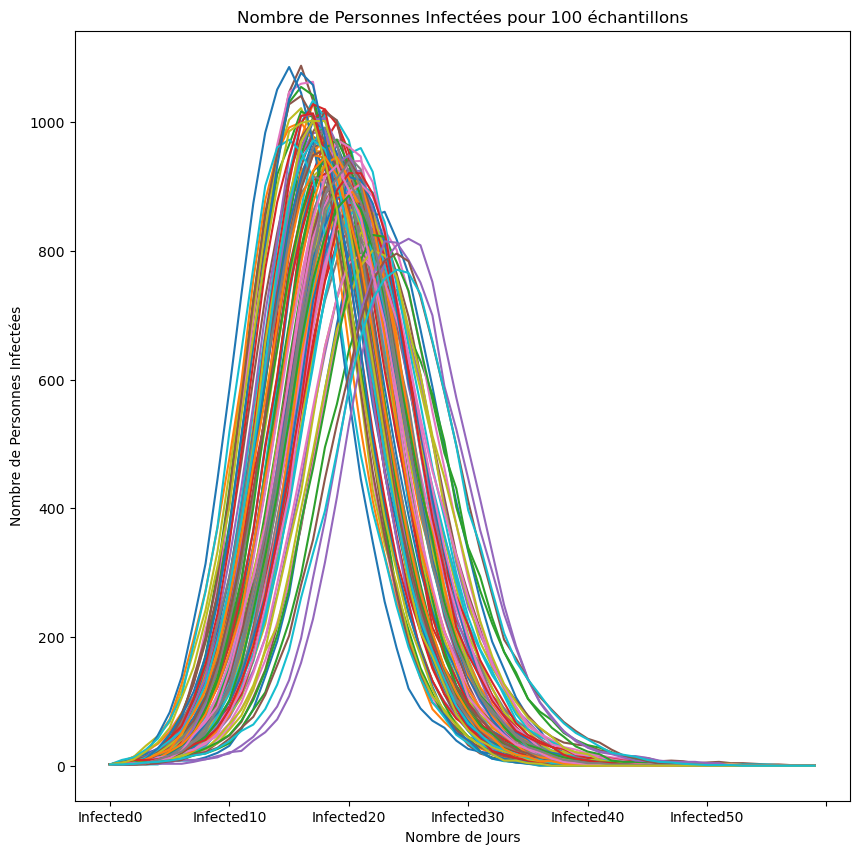

In [13]:
number_of_steps = 60
dataset_all.T[:number_of_steps].plot(legend=False, figsize=(10, 10), 
                                     xlabel='Nombre de Jours', 
                                     ylabel='Nombre de Personnes Infectées',
                                     title='Nombre de Personnes Infectées pour 100 échantillons')

plt.savefig('InfectedNum.png', bbox_inches='tight', dpi=300)
plt.show()

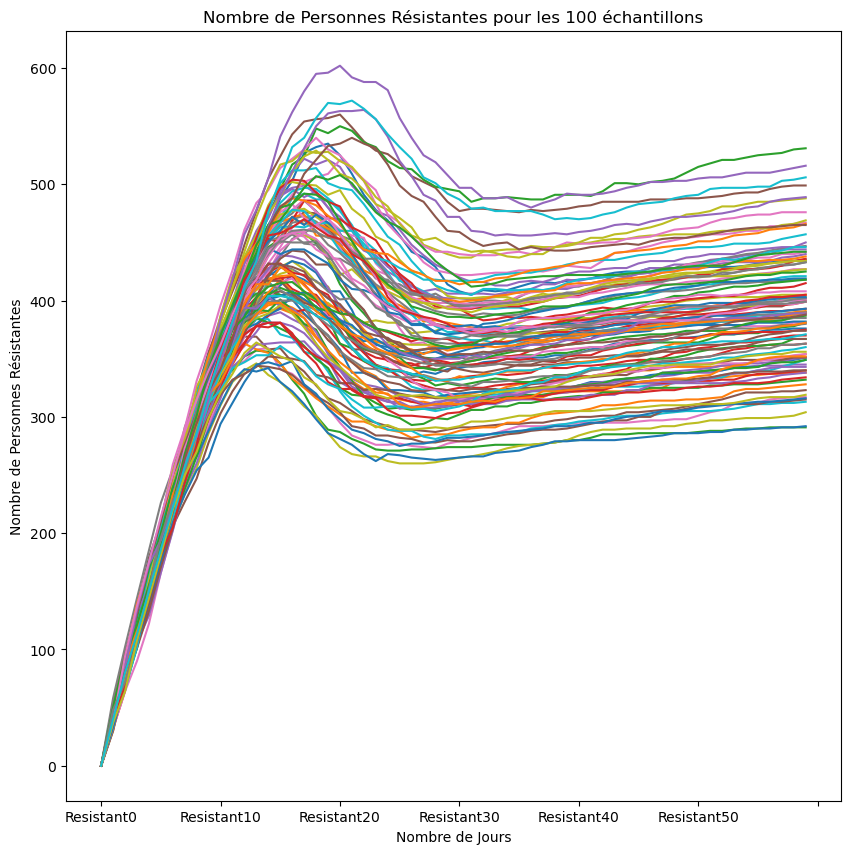

In [14]:
number_of_steps = 60
dataset_all.T[number_of_steps:number_of_steps*2].plot(legend=False, figsize=(10, 10), 
                                     xlabel='Nombre de Jours', 
                                     ylabel='Nombre de Personnes Résistantes',
                                     title='Nombre de Personnes Résistantes pour les 100 échantillons')

plt.savefig('InfectedNum.png', bbox_inches='tight', dpi=300)
plt.show()

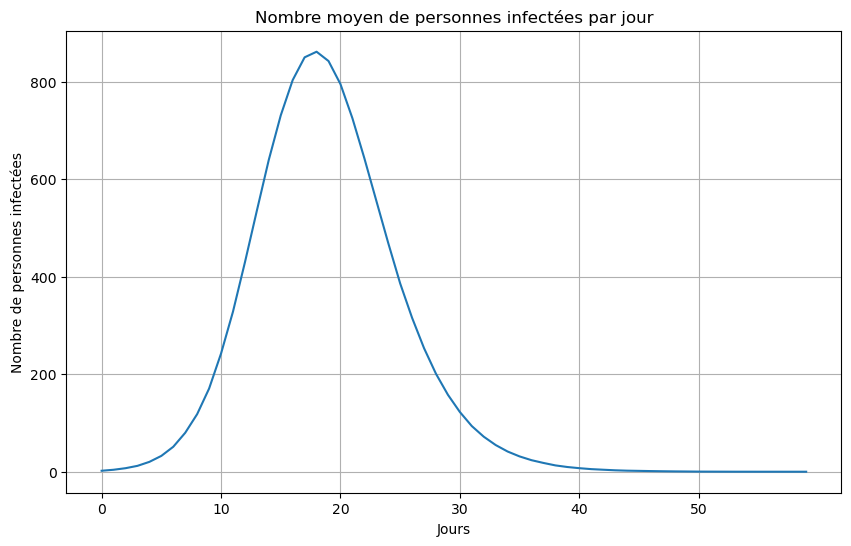

In [21]:
# Calculate average number of infected individuals per day
average_infected_per_day = daily_scores['Infected']

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(range(number_of_steps), average_infected_per_day)
plt.title('Nombre moyen de personnes infectées par jour')
plt.xlabel('Jours')
plt.ylabel('Nombre de personnes infectées')
plt.xticks(range(0, number_of_steps, 10))  # Espacement de 10 jours sur l'axe des abscisses
plt.grid(True)
plt.show()

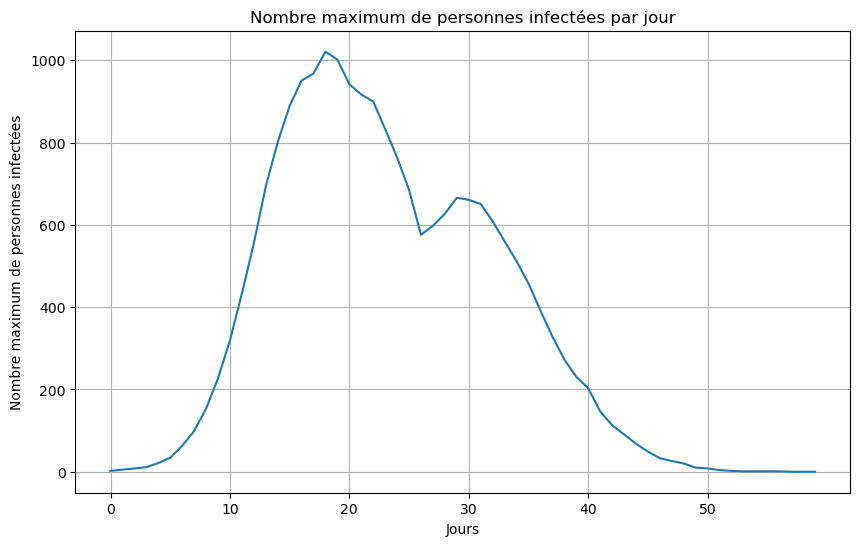

In [23]:
# Calculer le nombre maximum de personnes infectées par jour
max_infected_per_day = dataset_all.max()

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(range(number_of_steps), max_infected_per_day)
plt.title('Nombre maximum de personnes infectées par jour')
plt.xlabel('Jours')
plt.ylabel('Nombre maximum de personnes infectées')
plt.xticks(range(0, number_of_steps, 10))  # Espacement de 10 jours sur l'axe des abscisses
plt.grid(True)
plt.show()

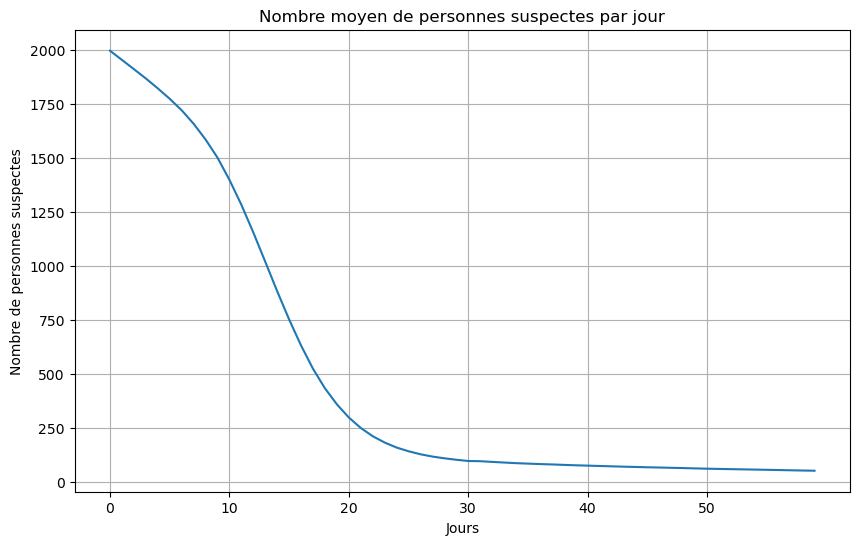

In [26]:
# Calculate average number of infected individuals per day
average_infected_per_day = daily_scores['Susceptible']

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(range(number_of_steps), average_infected_per_day)
plt.title('Nombre moyen de personnes suspectes par jour')
plt.xlabel('Jours')
plt.ylabel('Nombre de personnes suspectes')
plt.xticks(range(0, number_of_steps, 10))  # Espacement de 10 jours sur l'axe des abscisses
plt.grid(True)
plt.show()

## Anomalities and Machine Learning Predictions

### Anomalies of a Simulation

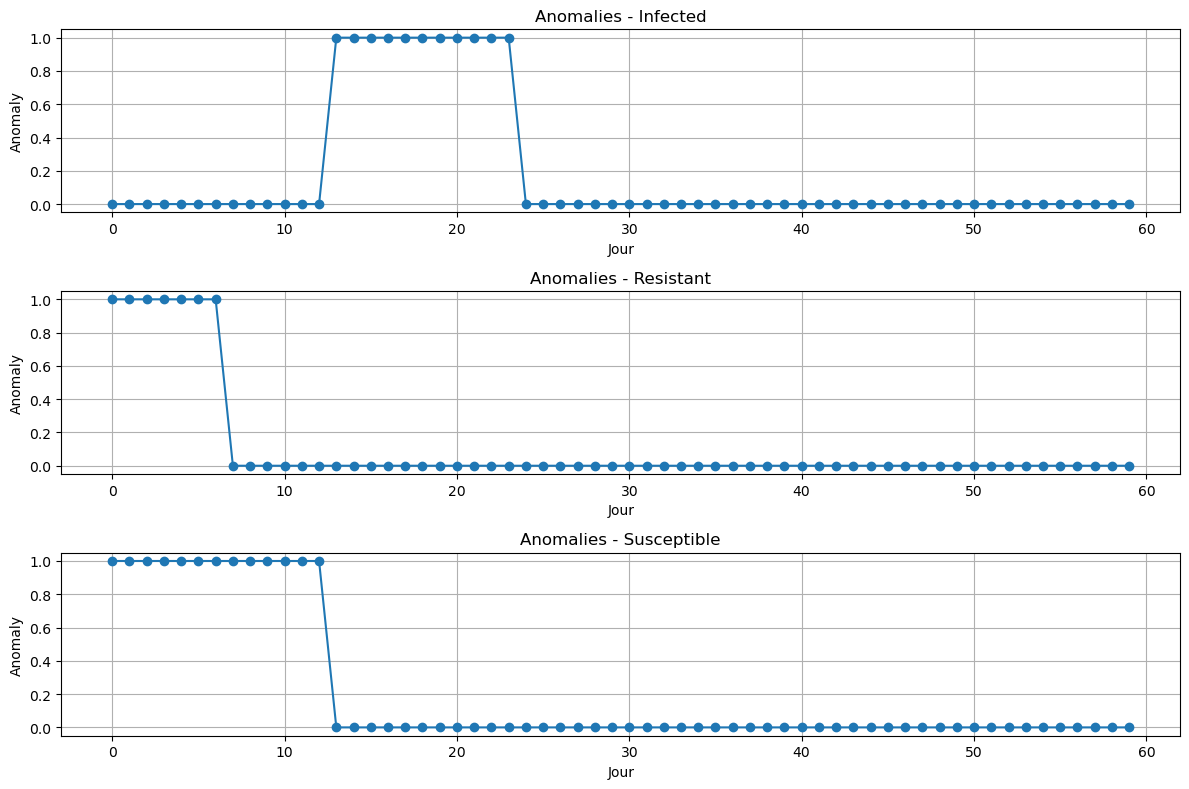

In [41]:
# Select one simulation (e.g., the first simulation)
simulation_index = 0
one_simulation = dataset_all.iloc[simulation_index]

# Calculate Z-score for each type (Infected, Resistant, Susceptible)
z_scores_infected = (one_simulation.iloc[:number_of_steps] - one_simulation.iloc[:number_of_steps].mean()) / one_simulation.iloc[:number_of_steps].std()
z_scores_resistant = (one_simulation.iloc[number_of_steps:2*number_of_steps] - one_simulation.iloc[number_of_steps:2*number_of_steps].mean()) / one_simulation.iloc[number_of_steps:2*number_of_steps].std()
z_scores_susceptible = (one_simulation.iloc[2*number_of_steps:] - one_simulation.iloc[2*number_of_steps:].mean()) / one_simulation.iloc[2*number_of_steps:].std()

# Set threshold for anomaly detection (e.g., z-score > 3 or < -3)
threshold = 1

# Identify anomalies based on threshold
anomalies_infected = np.abs(z_scores_infected) > threshold
anomalies_resistant = np.abs(z_scores_resistant) > threshold
anomalies_susceptible = np.abs(z_scores_susceptible) > threshold

# Plot anomalies for each type
plt.figure(figsize=(12, 8))

# Plot anomalies for 'Infected'
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(anomalies_infected)), anomalies_infected, marker='o', linestyle='-')
plt.title('Anomalies - Infected')
plt.xlabel('Jour')
plt.ylabel('Anomaly')
plt.grid(True)

# Plot anomalies for 'Resistant'
plt.subplot(3, 1, 2)
plt.plot(np.arange(len(anomalies_resistant)), anomalies_resistant, marker='o', linestyle='-')
plt.title('Anomalies - Resistant')
plt.xlabel('Jour')
plt.ylabel('Anomaly')
plt.grid(True)

# Plot anomalies for 'Susceptible'
plt.subplot(3, 1, 3)
plt.plot(np.arange(len(anomalies_susceptible)), anomalies_susceptible, marker='o', linestyle='-')
plt.title('Anomalies - Susceptible')
plt.xlabel('Jour')
plt.ylabel('Anomaly')
plt.grid(True)

plt.tight_layout()
plt.show()

### SVM et Random Forest

In [47]:
# Separate features (X) and target (y)
X = daily_scores.iloc[:, 1:]  # Features: Resistant and Susceptible
y = daily_scores.iloc[:, 0]   # Target: Infected

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Initialize and train the SVR model
# You can try different kernels and hyperparameters
svr_model = SVR(kernel='rbf', C=100, gamma=0.1)
svr_model.fit(X_train, y_train)

# Initialize and train the Random Forest Regressor model
# You can adjust hyperparameters such as n_estimators, max_depth, etc.
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
svr_predictions = svr_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

# Evaluate the models
svr_mse = mean_squared_error(y_test, svr_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)

print('SVR Mean Squared Error:', svr_mse)
print('Random Forest Mean Squared Error:', rf_mse)


SVR Mean Squared Error: 0.013768417445741888
Random Forest Mean Squared Error: 0.007957162170243908


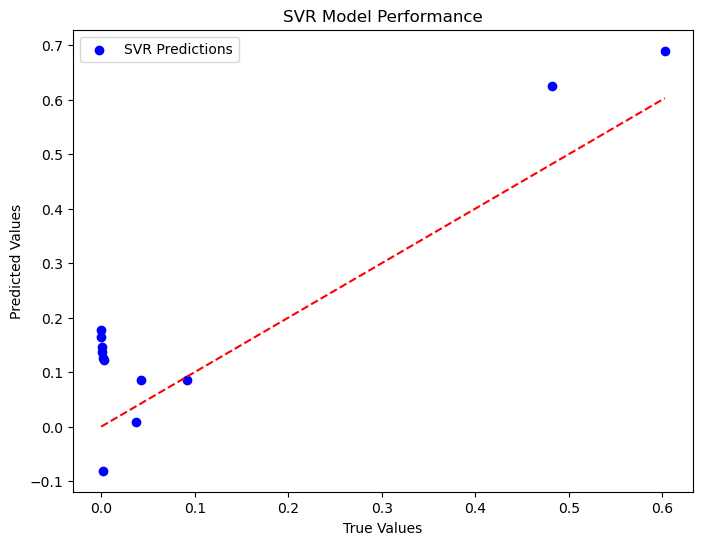

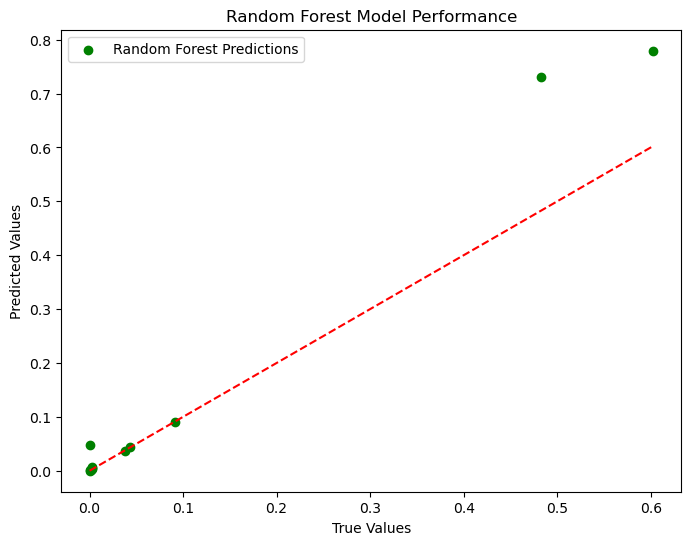

In [48]:
# Plotting SVR predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_predictions, color='blue', label='SVR Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('SVR Model Performance')
plt.legend()
plt.show()

# Plotting Random Forest predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_predictions, color='green', label='Random Forest Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Model Performance')
plt.legend()
plt.show()